In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fivethirtyeight_uber_pickups_in_new_york_city_path = kagglehub.dataset_download('fivethirtyeight/uber-pickups-in-new-york-city')

print('Data source import complete.')


100%|██████████| 109M/109M [00:01<00:00, 85.0MB/s]

Extracting files...


Data source import complete.


# Introduction
The rise of ride-hailing services has transformed urban transportation, with Uber playing a pivotal role in this revolution. This project presents an exploratory data analysis (EDA) of Uber pickup data in New York City for the year 2014, sourced from Kaggle. This dataset provides a detailed view of over 4.5 million Uber pickups, offering rich insights into ride demand, temporal trends, and geographic patterns.

The primary objective of this analysis is to uncover trends in Uber's service usage across New York City's boroughs, with a focus on temporal dynamics such as peak hours, days, and seasonal variations. Additionally, the project explores spatial patterns in pickup locations to identify areas of high demand, which could provide actionable insights for optimizing operations and improving customer experience.

# Import and Inspect Dataset

In [3]:
!pip install geoplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 19.9 MB/s eta 0:00:00


In [4]:
# import packages
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import folium
from folium import plugins
from shapely.geometry import Point
import warnings

In [5]:
# ignore warnings
warnings.filterwarnings('ignore')

In [6]:
# import dataset
path = kagglehub.dataset_download("fivethirtyeight/uber-pickups-in-new-york-city")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'uber-pickups-in-new-york-city' dataset.
Path to dataset files: /kaggle/input/uber-pickups-in-new-york-city


In [7]:
# browse file in the path
os.listdir(path)

['uber-raw-data-may14.csv',
 'other-FHV-services_jan-aug-2015.csv',
 'other-Prestige_B01338.csv',
 'other-Firstclass_B01536.csv',
 'other-Skyline_B00111.csv',
 'other-Lyft_B02510.csv',
 'uber-raw-data-apr14.csv',
 'uber-raw-data-jul14.csv',
 'other-Dial7_B00887.csv',
 'other-Diplo_B01196.csv',
 'other-Federal_02216.csv',
 'Uber-Jan-Feb-FOIL.csv',
 'uber-raw-data-jun14.csv',
 'other-Highclass_B01717.csv',
 'other-American_B01362.csv',
 'uber-raw-data-sep14.csv',
 'uber-raw-data-aug14.csv',
 'other-Carmel_B00256.csv',
 'uber-raw-data-janjune-15.csv']

In [8]:
# extract and contact data for uber 2014
uber2014 = [f for f in os.listdir(path) if f.endswith('14.csv')]
uber2014 = pd.concat(pd.read_csv(path + '/' + filename, parse_dates=['Date/Time']) for filename in uber2014) # concat all files in "14"


In [9]:
# preview the data
uber2014.head()

,Date/Time,Lat,Lon,Base
0,2014-05-01 00:02:00,40.7521,-73.9914,B02512
1,2014-05-01 00:06:00,40.6965,-73.9715,B02512
2,2014-05-01 00:15:00,40.7464,-73.9838,B02512
3,2014-05-01 00:17:00,40.7463,-74.0011,B02512
4,2014-05-01 00:17:00,40.7594,-73.9734,B02512


In [10]:
# data type inspection
uber2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 829274
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  datetime64[ns]
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 173.0+ MB


In [11]:
# null inspection
uber2014.isna().sum()

,0
Date/Time,0
Lat,0
Lon,0
Base,0


In [12]:
# basic stats overview
uber2014.describe()

,Date/Time,Lat,Lon
count,4534327,4.534327e+06,4.534327e+06
mean,2014-07-11 18:50:50.578152704,4.073926e+01,-7.397302e+01
min,2014-04-01 00:00:00,3.965690e+01,-7.492900e+01
25%,2014-05-28 15:18:00,4.072110e+01,-7.399650e+01
50%,2014-07-17 14:45:00,4.074220e+01,-7.398340e+01
75%,2014-08-27 21:55:00,4.076100e+01,-7.396530e+01
max,2014-09-30 22:59:00,4.211660e+01,-7.206660e+01
std,NaN,3.994991e-02,5.726670e-02


# EDA

In [13]:
# feature enrichment
uber2014['date'] = uber2014['Date/Time'].dt.strftime('%Y-%m-%d')
uber2014['month'] = uber2014['Date/Time'].dt.month
uber2014['day_of_month'] = uber2014['Date/Time'].dt.day
uber2014['day_of_week'] = uber2014['Date/Time'].dt.day_name()
uber2014['day_of_week'] = uber2014['Date/Time'].dt.day_name().astype('category')
uber2014['hour_of_day'] = uber2014['Date/Time'].dt.hour
uber2014['weekend'] = uber2014['Date/Time'].dt.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [14]:
# order for day_of_week
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [15]:
# match the geo info with boroughs info
# - Loads a GeoDataFrame of NYC borough polygons from the geoplot dataset.
# - Converts the coordinate reference system (CRS) to EPSG:4326, which uses latitude and longitude (WGS84) — matching your Uber data.
# - Creates a new GeoDataFrame from your Uber dataset.
# - Adds a geometry column with Point objects from longitude (Lon) and latitude (Lat).
# - Sets the CRS to EPSG:4326 to ensure compatibility with the borough polygons.
# - Performs a spatial join: for each Uber pickup point, finds the borough polygon it falls within.
# - how='left' keeps all Uber records, even if no match is found.
# - Adds borough attributes (like BoroName) to matching rows.
# - Adds a new column BoroName to the original Uber DataFrame.
# - If a pickup point didn't match any borough (e.g., outside NYC), it's labeled as 'Other'.

nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs')).to_crs("EPSG:4326")
geo_df = gpd.GeoDataFrame(uber2014, geometry=gpd.points_from_xy(uber2014.Lon, uber2014.Lat), crs="EPSG:4326")
combined_geo = gpd.sjoin(geo_df, nyc_boroughs, how='left', predicate='within')
uber2014['BoroName'] = combined_geo['BoroName'].fillna('Other')
uber2014.head()

,Date/Time,Lat,Lon,Base,date,month,day_of_month,day_of_week,hour_of_day,weekend,BoroName
0,2014-05-01 00:02:00,40.7521,-73.9914,B02512,2014-05-01,5,1,Thursday,0,0,Manhattan
1,2014-05-01 00:06:00,40.6965,-73.9715,B02512,2014-05-01,5,1,Thursday,0,0,Brooklyn
2,2014-05-01 00:15:00,40.7464,-73.9838,B02512,2014-05-01,5,1,Thursday,0,0,Manhattan
3,2014-05-01 00:17:00,40.7463,-74.0011,B02512,2014-05-01,5,1,Thursday,0,0,Manhattan
4,2014-05-01 00:17:00,40.7594,-73.9734,B02512,2014-05-01,5,1,Thursday,0,0,Manhattan


Ride demand steadily increased throughout the year, with September seeing the highest volume. Daily ride counts remain fairly stable, though certain days had slight dips, which could be linked to holidays or events. Thursday and Friday had the most rides, likely due to work commutes and people heading out for the weekend, while Sunday had the least demand. Looking at the hourly trends, evening (5-8 PM) rush hours were the busiest, with other spikes around 10 PM to midnight and morning (6-9 AM), likely from people going out at night and commute to work.

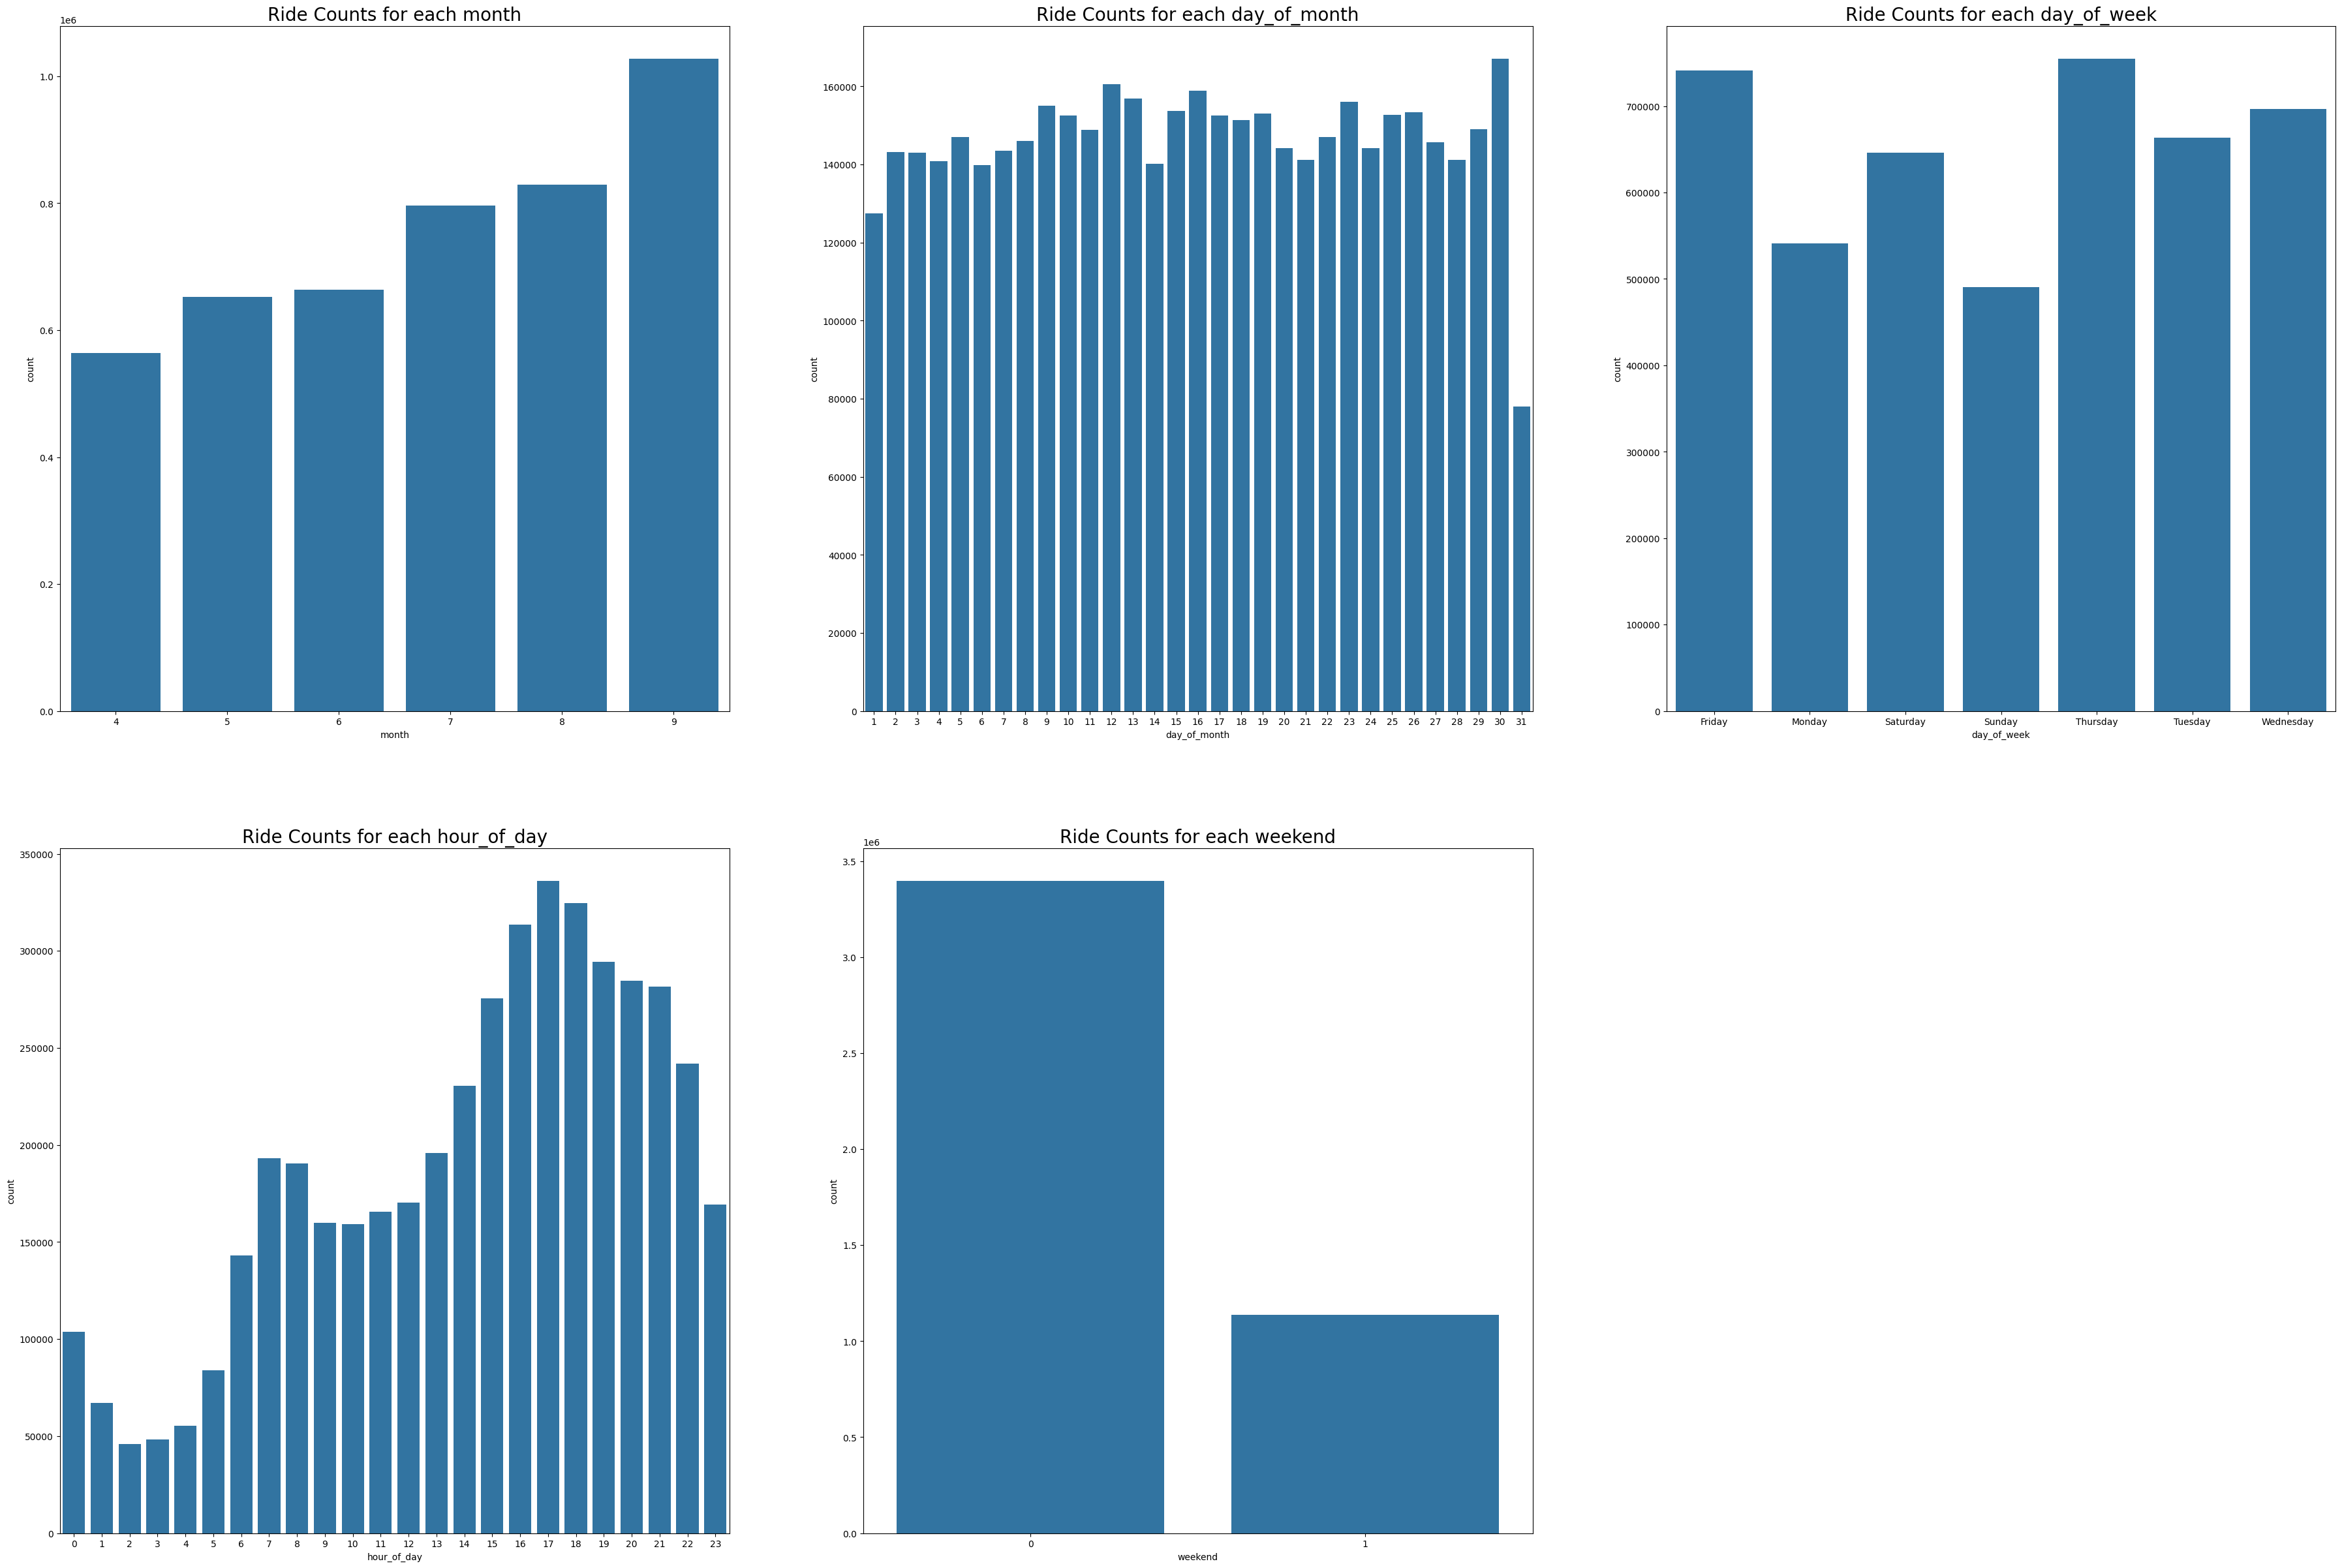

In [16]:
# distribution inspection
time_cols = ['month', 'day_of_month', 'day_of_week', 'hour_of_day', 'weekend']
fig, ax = plt.subplots(2, 3, figsize=(45, 30))
for col, axis in zip(time_cols, ax.flat):
    sns.countplot(data=uber2014, x=col, ax=axis)
    axis.set_title(f"Ride Counts for each {col}")
    axis.title.set_size(20)
ax[1, 2].axis('off')
plt.show()

In April, there is a notable increase in ride counts towards the end of the month, while May and June show more pronounced fluctuations with multiple peaks and drops, indicating varying demand throughout these months. July and August continue to display high variability, with several sharp increases followed by steep declines, possibly aligning with weekend spike. September stands out with an overall increase in daily ride counts compared to previous months, peaking above 40,000 rides on certain days. This could be attributed to business growth, and seasonal changes, such as back-to-school activities and the return of work routines after summer.

Overall, the data reveals that Uber demand follows a non-uniform pattern with periodic spikes, suggesting that external factors such as weekdays versus weekends, holidays, and possibly weather conditions might be influencing ride counts. Further analysis could explore correlations with such factors to better understand the driving forces behind these fluctuations.

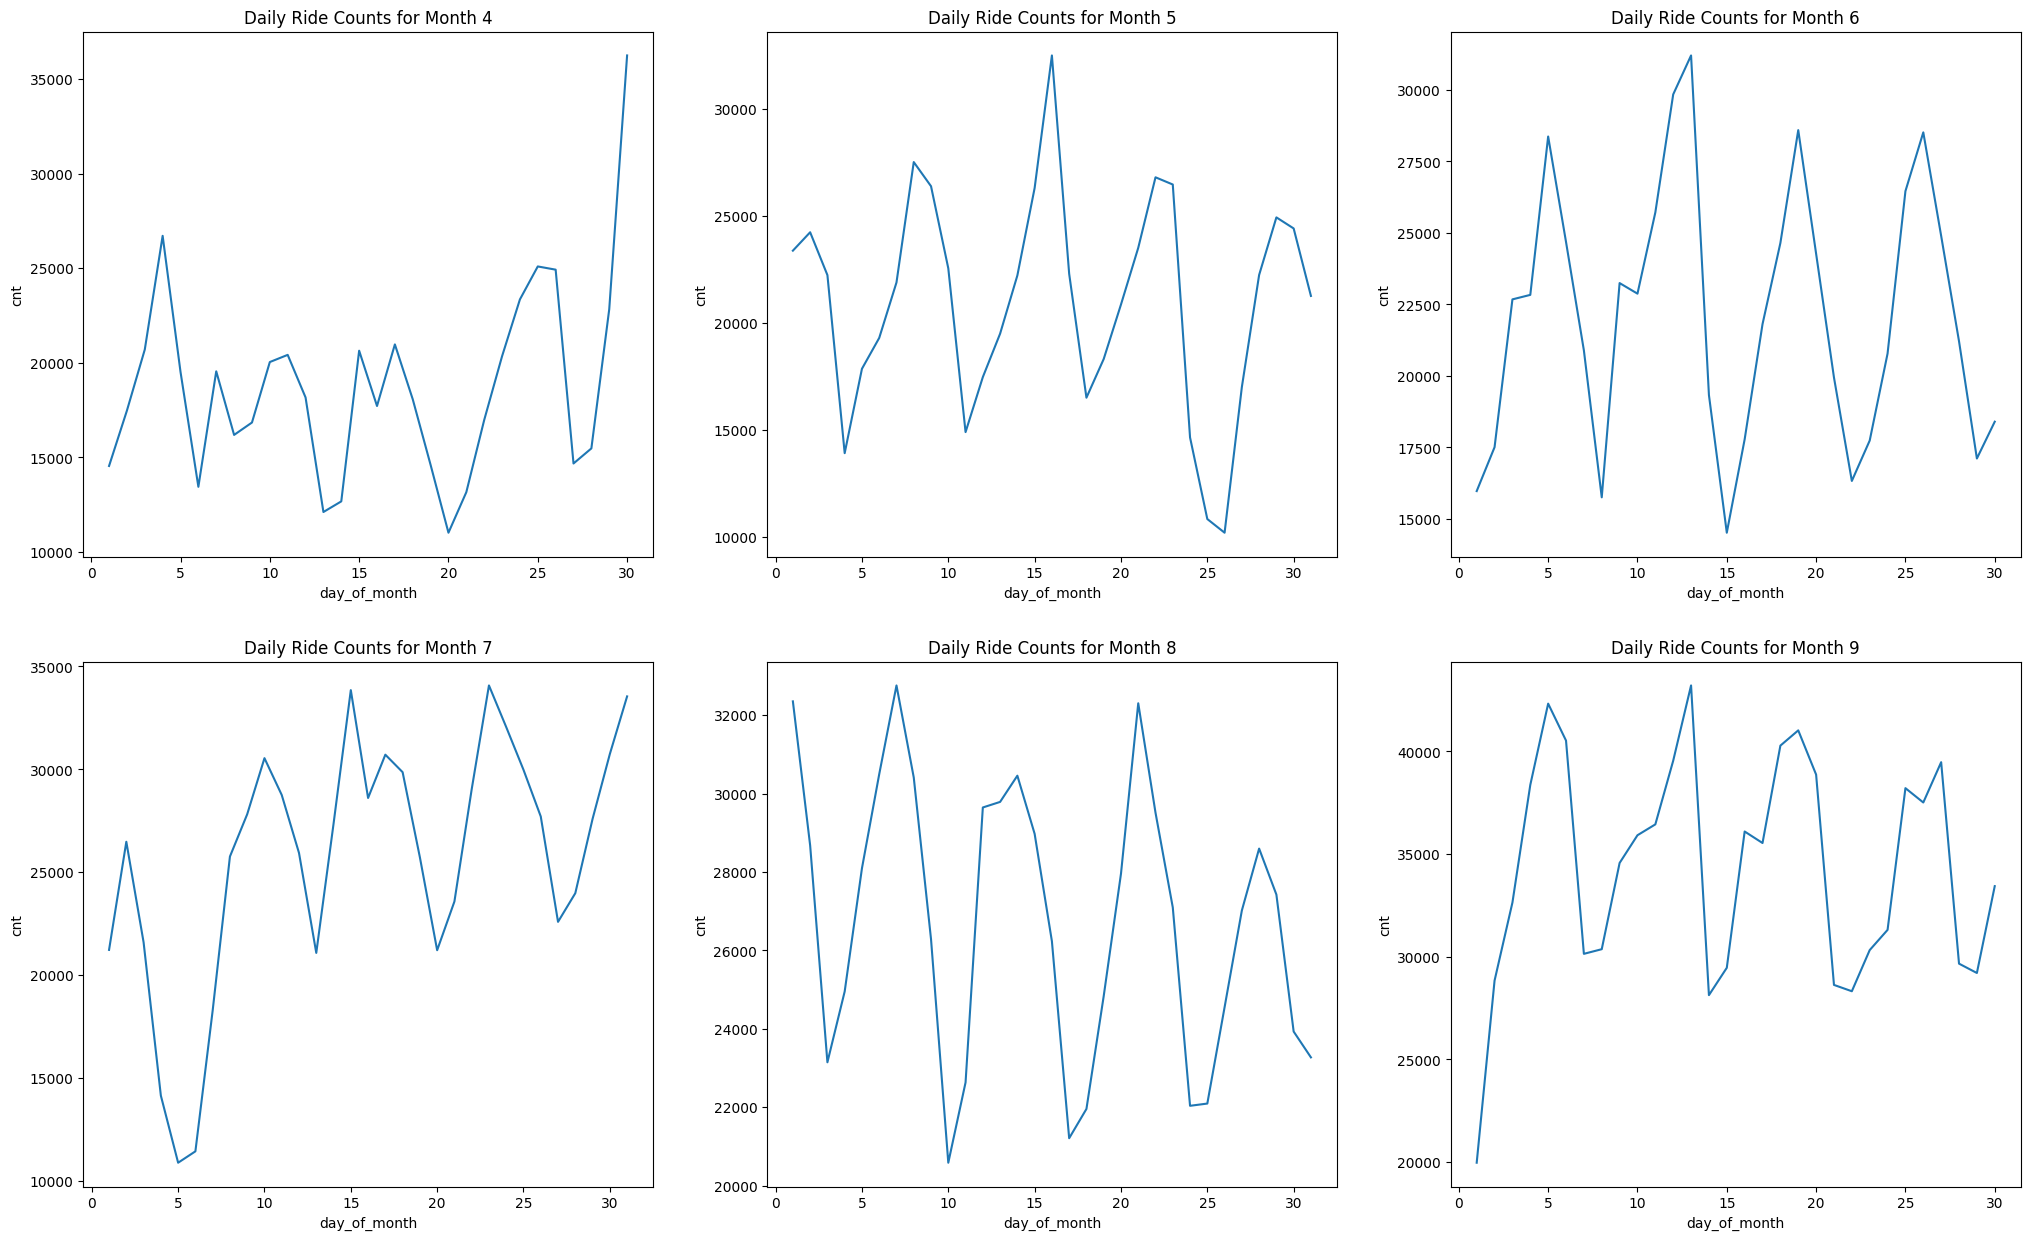

In [17]:
# plot ride trend of day of month for each month
uber2014_top_day_month = uber2014.groupby(['month', 'day_of_month'])['day_of_month'].count().reset_index(name='cnt')
months = [4, 5, 6, 7, 8, 9]
uber2014_top_day_month
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
for month, axis in zip(months, ax.flat):
    month_df = uber2014_top_day_month[uber2014_top_day_month['month'] == month]
    sns.lineplot(month_df, x = 'day_of_month', y='cnt', ax=axis)
    axis.set_title(f"Daily Ride Counts for Month {month}")
plt.show()

Further into the weekends and weekdays diviation, Uber rides follow different patterns on weekdays and weekends. Weekday rides peak around 7-9 AM and 4-7 PM, matching typical commuting hours, while weekend rides are more evenly spread out throughout the day. Late-night rides (midnight to 2 AM) are slightly higher on weekends, likely due to nightlife. Afternoon and evening rides (12-9 PM) gradually increase for both, but weekday demand is consistently higher. This suggests that Uber was mainly used for commuting on weekdays, while weekends saw more leisure-based travel.

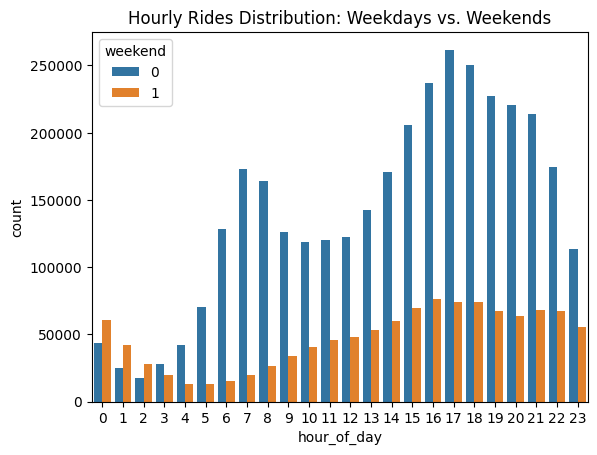

In [18]:
# plot hourly rides distribution weedays vs. weekends
sns.countplot(data=uber2014, x='hour_of_day', hue='weekend').set(title='Hourly Rides Distribution: Weekdays vs. Weekends')
plt.show()

The plot below shows that Manhattan dominates Uber rides in 2014, with significantly more pickups than any other borough. Brooklyn and Queens have moderate ride counts, while the Bronx and Staten Island have very few. This suggests that Uber usage was heavily concentrated in Manhattan, likely due to its high population density, business districts, and nightlife. Other boroughs saw less demand, possibly because of lower ride necessity or availability.

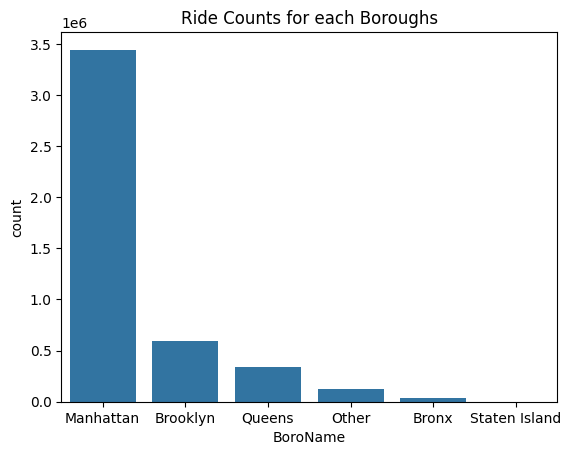

In [19]:
# plot ride counts for each boroughs
sns.countplot(data=uber2014, x='BoroName').set(title="Ride Counts for each Boroughs")
plt.show()

The plot compares Uber rides across boroughs on weekdays (blue) and weekends (orange). Manhattan dominates both weekday and weekend rides, but weekday demand is much higher, suggesting heavy reliance on Uber for work commutes. Brooklyn and Queens have a more balanced distribution, with weekend rides making up a larger share comparing to Manhattan, likely due to leisure travel. The Bronx and Staten Island have minimal ride activity, indicating lower demand or alternative transportation preferences. Overall, the data confirms that Manhattan is the core of Uber activity, with other boroughs seeing more varied usage patterns between weekdays and weekends.

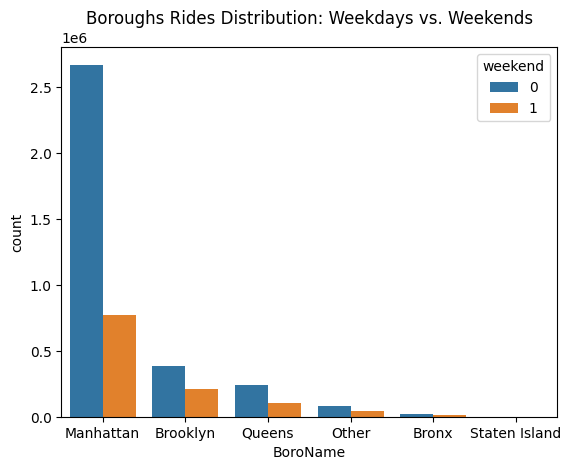

In [20]:
# plot boroughs rides distribution: weekdays vs. weekends
sns.countplot(data=uber2014, x='BoroName', hue='weekend').set(title="Boroughs Rides Distribution: Weekdays vs. Weekends")
plt.show()

Manhattan dominates the ride volume throughout all days, showing the highest number of rides on weekdays, peaking on Thursday and Friday. The number of rides slightly decreases on weekends but remains significantly higher than in any other borough. Brooklyn and Queens follow as the next most active boroughs, with a relatively steady number of rides throughout the week. Brooklyn shows a slight increase on weekends compared to weekdays. The other boroughs, including Bronx, Staten Island, and the "Other" category, contribute a comparatively smaller number of rides, indicating a lower Uber demand in these areas. This suggests that Uber rides are most frequently taken in Manhattan, aligning with its high population density and business activities, while Brooklyn sees increased demand on weekends, possibly due to leisure and nightlife activities.

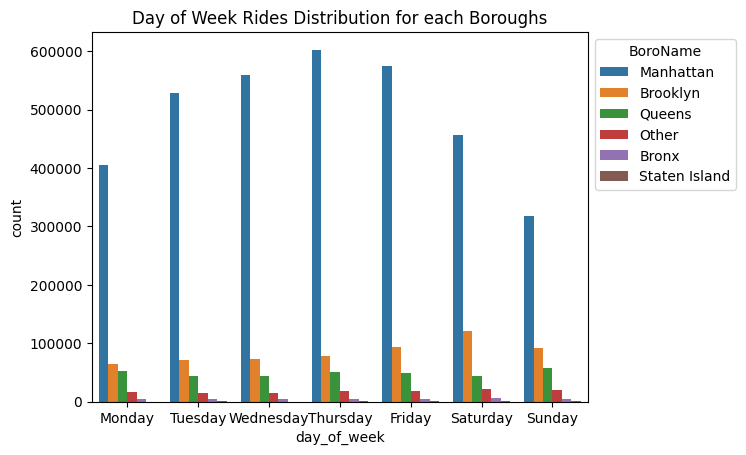

In [21]:
# plot day of week rides distribtion for each boroughs
sns.countplot(data=uber2014, x='day_of_week', hue='BoroName', order=dow_order).set(title="Day of Week Rides Distribution for each Boroughs")
plt.legend(title='BoroName', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Manhattan consistently records the highest number of ride pickups throughout all months, with a clear upward trend peaking in September. This suggests a growing demand for Uber services in Manhattan. Brooklyn and Queens show moderate ride volumes compared to Manhattan, with Brooklyn experiencing a slight increase in demand in the later months. The other boroughs, including Bronx, Staten Island, and the "Other" category also have increasing trends. The general trend across all boroughs suggests that ride demand rises steadily as months progress.

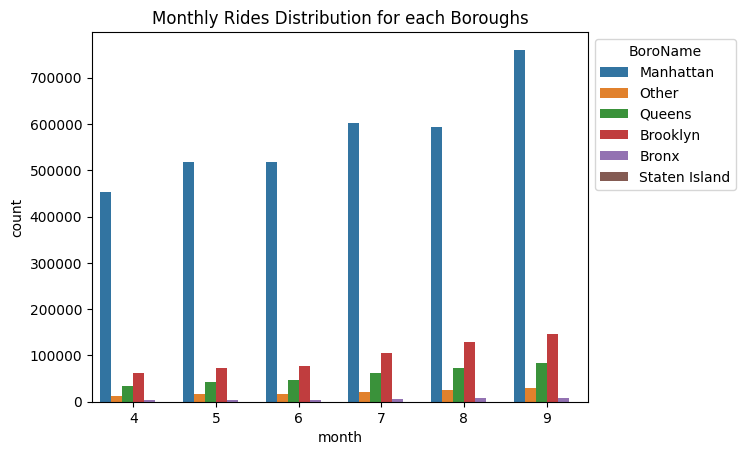

In [22]:
# plot monthly rides distribution for each boroughs
sns.countplot(data=uber2014, x='month', hue='BoroName').set(title="Monthly Rides Distribution for each Boroughs")
plt.legend(title='BoroName', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Business districts, such as Lower Manhattan and Midtown, exhibit the most concentrated pickup activity, especially during peak commuting hours. These areas are major economic hubs where professionals frequently rely on Uber for daily transportation. University campuses, including Columbia University and New York University, also show substantial ride demand, likely driven by student mobility between academic buildings, dormitories, and nearby transit points. Residential neighborhoods contribute to a steady flow of pickups. Plazas and public spaces, such as Times Square, Union Square, and Grand Army Plaza, emerge as additional hotspots for Uber pickups. These areas attract high foot traffic from both tourists and locals, leading to consistent ride demand. The presence of entertainment venues, shopping centers, and event spaces further amplifies pickup activity in these locations.

The spatial distribution of Uber rides reflects a strong correlation between urban infrastructure and ride demand. Business districts dominate during weekdays, university areas maintain stable activity throughout the day, residential neighborhoods experience peak demand in the mornings and evenings, and plazas serve as continuous pickup points due to their central role in city life. Understanding these patterns can help improve ride distribution, enhance service efficiency, and optimize urban transportation planning.

In [23]:
# heatmap for uber pickup locations
gdf = gpd.GeoDataFrame(uber2014, geometry=gpd.points_from_xy(x=uber2014.Lon, y=uber2014.Lat, crs='EPSG:4326'))[['month', 'day_of_month', 'day_of_week', 'hour_of_day', 'weekend', 'geometry']]
map = folium.Map(location=[40.7, -74], tiles="OpenStreetMap", zoom_start=10)
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf['geometry']]
plugins.HeatMap(heat_data).add_to(map)
map

Buffered data was truncated after reaching the output size limit.

# Summary
The exploratory data analysis of Uber pickups in New York City provides valuable insights into ride demand patterns across different temporal and spatial dimensions. The analysis reveals that ride activity is highest on weekdays, particularly from Tuesday to Friday, with a noticeable decline on weekends. Manhattan consistently records the highest number of pickups, followed by Brooklyn and Queens, while other boroughs contribute relatively fewer rides. Monthly trends indicate a steady increase in Uber demand from April to September, with the highest ride volumes observed in the late summer and early fall. Spatial analysis using heatmaps highlights the concentration of pickups in key urban areas, including business districts, university campuses, residential neighborhoods, and plazas.

Overall, the findings suggest that Uber ride demand is influenced by work schedules, academic activities, residential commuting patterns, and tourism. These insights can inform operational strategies for ride allocation, pricing optimization, and urban transportation planning to enhance efficiency and customer satisfaction.

Thank you for taking the time to explore this analysis of Uber pickup patterns in New York City. I hope you found the insights valuable and informative. If you enjoyed this exploration, feel free to give it an upvote—your support is greatly appreciated! If you have any questions, feedback, or additional thoughts, don’t hesitate to leave a comment. I’d love to hear your perspectives and discuss any aspects of the analysis further.🚀